In [454]:
import pandas as pd

train = pd.read_csv('~/Aiffel/DATAThon/playground-series-s4e11/train.csv')
test = pd.read_csv('~/Aiffel/DATAThon/playground-series-s4e11/test.csv')

- 목표: Deppession (이진 분류)
- 데이터 특징: 범주형 + 수치형 + 민감 응답 혼합

## 1. 데이터 확인

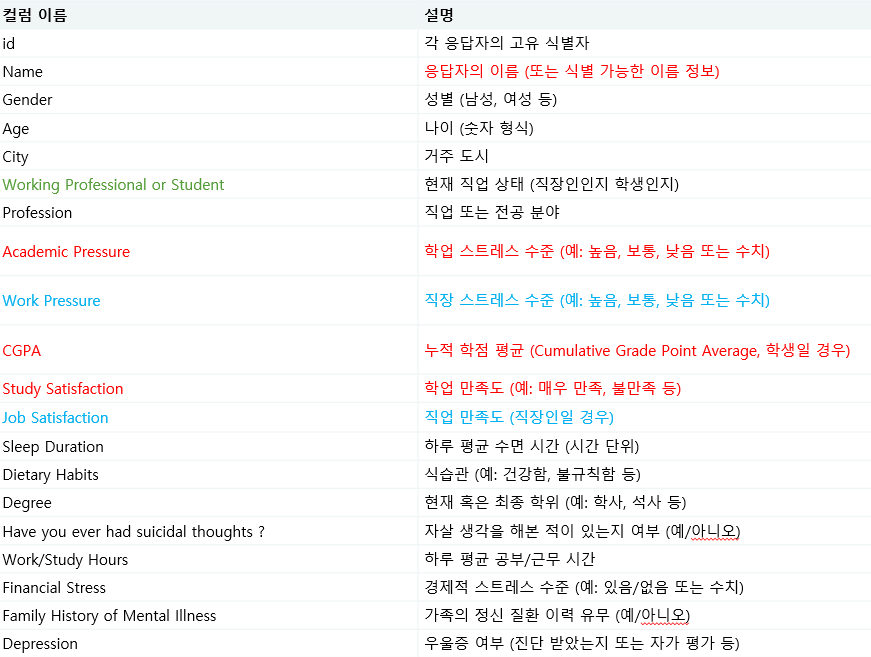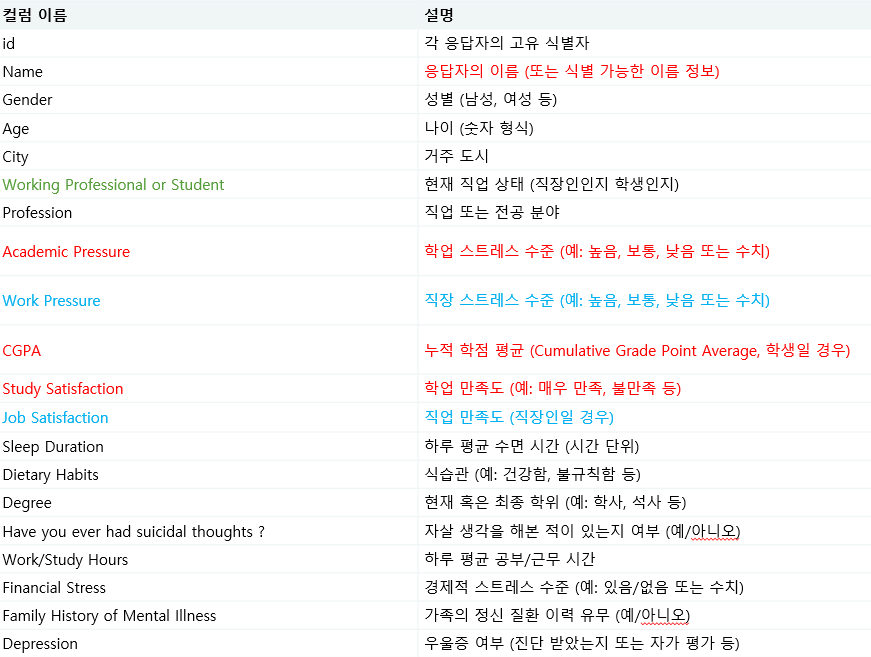

In [455]:
train.head()

,id,Name,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,0,Aaradhya,Female,49.0,Ludhiana,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,Vivan,Male,26.0,Varanasi,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,Yuvraj,Male,33.0,Visakhapatnam,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,Yuvraj,Male,22.0,Mumbai,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,Rhea,Female,30.0,Kanpur,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [456]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  object 
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  object 
 5   Working Professional or Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic Pressure                      27897 non-null   float64
 8   Work Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study Satisfaction                     27897 non-null   

## 전처리

In [457]:
import pandas as pd

train = pd.read_csv('~/Aiffel/DATAThon/playground-series-s4e11/train.csv')
test = pd.read_csv('~/Aiffel/DATAThon/playground-series-s4e11/test.csv')

### 0. 삭제

In [458]:
# name 살리고 싶었는데 원핫인코딩하면 차원이 커져서 오류가 생기길래 지웠습니다

train.drop(columns=['id'], inplace=True)
train.drop(columns=['Name'], inplace=True)

### 1. Sleep Duration

- 기준을 만들어서 float 형으로 변환

In [459]:
train['Sleep Duration'].value_counts()

Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
6-8 hours                4
1-6 hours                4
No                       4
9-11 hours               2
10-11 hours              2
Sleep_Duration           2
Unhealthy                2
45                       2
8-9 hours                2
10-6 hours               1
9-5                      1
45-48 hours              1
3-6 hours                1
Work_Study_Hours         1
49 hours                 1
than 5 hours             1
Pune                     1
9-6 hours                1
8 hours                  1
35-36 hours              1
Indore                   1
1-3 hours                1
55-66 hours              1
Moderate                 1
40-45 hours              1
1-2 hours                1
9-5 hours                1
Name: count, 

In [460]:
# 이상치, 알 수 없는 값들 제거
delete_values = [
    'Indore', 'Pune', 'Moderate', 'Unhealthy', 'Sleep_Duration',
    'Work_Study_Hours', 'No', '45', '49 hours', '55-66 hours', '40-45 hours', 
    '9-5 hours', '10-6 hours', '9-6 hours', '9-5', '45-48 hours', '35-36 hours'
]

train = train[~train['Sleep Duration'].isin(delete_values)].copy()

In [461]:
train['Sleep Duration'].value_counts()

Sleep Duration
Less than 5 hours    38784
7-8 hours            36969
More than 8 hours    32726
5-6 hours            32142
3-4 hours               12
6-7 hours                8
4-5 hours                7
2-3 hours                5
4-6 hours                5
1-6 hours                4
6-8 hours                4
8-9 hours                2
9-11 hours               2
10-11 hours              2
1-3 hours                1
1-2 hours                1
8 hours                  1
than 5 hours             1
3-6 hours                1
Name: count, dtype: int64

In [462]:
import numpy as np
import re

def convert_sleep_to_hours(val):
    try:
        val = str(val).strip().lower()

        # 특별 처리: 'than n hours' → 'less than n hours' 간주
        if 'than' in val and 'less' not in val and 'more' not in val:
            match = re.search(r'\d+', val)
            if match:
                return float(match.group()) - 0.5

        # Less than n hours → n - 0.5
        if 'less than' in val:
            match = re.search(r'\d+', val)
            if match:
                return float(match.group()) - 0.5

        # More than n hours → n + 0.5
        elif 'more than' in val:
            match = re.search(r'\d+', val)
            if match:
                return float(match.group()) + 0.5

        # 정확히 n hours → 숫자만 추출
        elif re.match(r'^\d+\s*hours$', val):
            return float(re.findall(r'\d+', val)[0])

        # n-m hours 또는 n–n → 평균값
        elif re.search(r'\d+\s*[-–~]\s*\d+', val):
            nums = [int(n) for n in re.findall(r'\d+', val)]
            if len(nums) == 2:
                return sum(nums) / 2

        # 숫자만 → 그대로
        elif re.match(r'^\d+(\.\d+)?$', val):
            return float(val)

        # 나머지는 이상값으로 간주
        else:
            return np.nan

    except:
        return np.nan


In [463]:
train['Sleep Duration'] = train['Sleep Duration'].apply(convert_sleep_to_hours)


In [464]:
train['Sleep Duration'].value_counts()

Sleep Duration
4.5     38793
7.5     36969
8.5     32728
5.5     32142
3.5        16
6.5         8
5.0         5
2.5         5
7.0         4
10.5        2
10.0        2
1.5         1
2.0         1
8.0         1
Name: count, dtype: int64

In [465]:
print(train['Sleep Duration'].dtype)

float64


## 2. 결측치 처리

#### 2-1. 결측률 80%

- 파생 변수 만들어서(결측 여부) 의미 있는 누락 정보 보존 + 과적합 방지 할 것인지
- 아니면 값을 대체할지 

일단 파생 변수를 만들어 보겠음. 

In [466]:
# 1. CGPA 컬럼 제거
train.drop(columns=['CGPA'], inplace=True)

In [467]:
# 2. Academic Pressure 결측 여부 파생 변수
train['Academic_Pressure_missing'] = train['Academic Pressure'].isnull().astype(int)

# 3. Study Satisfaction 결측 여부 파생 변수
train['Study_Satisfaction_missing'] = train['Study Satisfaction'].isnull().astype(int)

In [468]:
train['Academic_Pressure_missing']

0         1
1         1
2         0
3         1
4         1
         ..
140695    1
140696    1
140697    1
140698    1
140699    0
Name: Academic_Pressure_missing, Length: 140677, dtype: int64

*결과 예시*

| Academic Pressure | Academic\_Pressure\_missing | Study Satisfaction | Study\_Satisfaction\_missing |
| ----------------- | --------------------------- | ------------------ | ---------------------------- |
| 3.0               | 0                           | 4.0                | 0                            |
| NaN               | 1                           | NaN                | 1                            |
| 2.0               | 0                           | NaN                | 1                            |


- 원래 컬럼의 nan은 어떻게 처리?

    - 파생 변수를 만들었기 때문에, 그대로 두어도 됨.
    - 결측 여부 정보를 이미 담고 있어서
    - 하지만 사용하는 모델에 따라 nan을 허용하지 않으면 대체해야 함

1. 평균값 대체
- 가능은 하지만 무분별한 평균 대체는 정보 손실 및 왜곡을 유발할 수 있음.
- 특히 결측 자체가 의미를 갖는 경우(예: 설문 무응답 → 스트레스 회피?)엔 단순 평균은 부적절할 수 있음.
- 
```
train['Academic Pressure'].fillna(train['Academic Pressure'].median(), inplace=True)
train['Study Satisfaction'].fillna(train['Study Satisfaction'].median(), inplace=True)
```

2. imputer로 값 채우기
- 권장되는 방식!

- 파생 변수 없이 평균값 대체만 하면
    - 결측값이 있었다는 정보를 완전히 잃어버림
    - 실제로 결측이 의미를 가지는 경우 오히려 성능 저하


In [469]:
# train['Academic Pressure'].fillna(train['Academic Pressure'].median(), inplace=True)
# train['Study Satisfaction'].fillna(train['Study Satisfaction'].median(), inplace=True)

In [470]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='mean')  # 또는 'median', 'most_frequent'
train['Academic Pressure'] = imputer.fit_transform(train[['Academic Pressure']])
train['Study Satisfaction'] = imputer.fit_transform(train[['Study Satisfaction']])

#### 2-2. 나머지 결측치 처리

In [471]:
train.isnull().sum()

Gender                                       0
Age                                          0
City                                         0
Working Professional or Student              0
Profession                               36625
Academic Pressure                            0
Work Pressure                            27914
Study Satisfaction                           0
Job Satisfaction                         27906
Sleep Duration                               0
Dietary Habits                               4
Degree                                       2
Have you ever had suicidal thoughts ?        0
Work/Study Hours                             0
Financial Stress                             4
Family History of Mental Illness             0
Depression                                   0
Academic_Pressure_missing                    0
Study_Satisfaction_missing                   0
dtype: int64

In [472]:
train = train[train['Financial Stress'].notnull()].copy()
train = train[train['Degree'].notnull()].copy()
train = train[train['Dietary Habits'].notnull()].copy()

In [473]:
# 평균으로 대체
train['Work Pressure'].fillna(train['Work Pressure'].mean(), inplace=True)
train['Job Satisfaction'].fillna(train['Job Satisfaction'].mean(), inplace=True)

/var/folders/hf/5rb3dt8x3mq707hsrnthhx2w0000gn/T/ipykernel_2006/1212537241.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Work Pressure'].fillna(train['Work Pressure'].mean(), inplace=True)
/var/folders/hf/5rb3dt8x3mq707hsrnthhx2w0000gn/T/ipykernel_2006/1212537241.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we

In [474]:
print(train.isnull().sum().sort_values(ascending=False).head())

Profession                   36617
Gender                           0
Dietary Habits                   0
Academic_Pressure_missing        0
Depression                       0
dtype: int64


#### 2-3. 범주형 결측치 처리

In [475]:
train['Profession'].fillna('Missing', inplace=True)

/var/folders/hf/5rb3dt8x3mq707hsrnthhx2w0000gn/T/ipykernel_2006/4215184188.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['Profession'].fillna('Missing', inplace=True)


In [476]:
print(train.isnull().sum().sort_values(ascending=False).head())

Gender                              0
Dietary Habits                      0
Academic_Pressure_missing           0
Depression                          0
Family History of Mental Illness    0
dtype: int64


### 3. 수치형 컬럼 스케일링

In [477]:
df.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression
count,140700.000000,140700.000000,27897.000000,112782.000000,27898.000000,27897.000000,112790.000000,140700.000000,140696.000000,140700.000000
mean,70349.500000,40.388621,3.142273,2.998998,7.658636,2.944940,2.974404,6.252679,2.988983,0.181713
std,40616.735775,12.384099,1.380457,1.405771,1.464466,1.360197,1.416078,3.853615,1.413633,0.385609
min,0.000000,18.000000,1.000000,1.000000,5.030000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,35174.750000,29.000000,2.000000,2.000000,6.290000,2.000000,2.000000,3.000000,2.000000,0.000000
50%,70349.500000,42.000000,3.000000,3.000000,7.770000,3.000000,3.000000,6.000000,3.000000,0.000000
75%,105524.250000,51.000000,4.000000,4.000000,8.920000,4.000000,4.000000,10.000000,4.000000,0.000000
max,140699.000000,60.000000,5.000000,5.000000,10.000000,5.000000,5.000000,12.000000,5.000000,1.000000


| 컬럼명                | 범위           | 평균 ± 표준편차           | 이유                               |
| ------------------ | ------------ | ----------------- | -------------------------------- |
| `Age`              | 18 \~ 60     | 평균40.4, std 12.4 | 넓은 범위. 다른 변수와 범위 차 큼             |
| `CGPA`             | 5.03 \~ 10.0 | 평균 7.66           | 모델에 따라 민감할 수 있음      |
| `Work/Study Hours` | 0 \~ 12      | 평균 6.25, std 3.85 | 0부터 시작, 12까지 존재 → 거리 기반 모델에 영향 큼 |
| `Financial Stress` | 1 \~ 5       | 평균 2.99           | 다른 스트레스 계열들과 통일된 스케일 유리          |

- 범위가 넓은 수치형 변수
    - 표준화를 적용하기

In [478]:
from sklearn.preprocessing import StandardScaler

scale_cols = ['Age', 'Sleep Duration', 'Work/Study Hours', 'Financial Stress']

scaler = StandardScaler()
train[scale_cols] = scaler.fit_transform(train[scale_cols])


In [479]:
train[scale_cols].describe()

,Age,Sleep Duration,Work/Study Hours,Financial Stress
count,1.406670e+05,1.406670e+05,1.406670e+05,1.406670e+05
mean,-1.801777e-16,4.182426e-17,-7.208119e-17,-2.848899e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.807815e+00,-3.113897e+00,-1.622485e+00,-1.406995e+00
25%,-9.196003e-01,-1.225789e+00,-8.440130e-01,-6.995951e-01
50%,1.301080e-01,-5.964194e-01,-6.554092e-02,7.804849e-03
75%,8.568292e-01,6.623196e-01,9.724218e-01,7.152048e-01
max,1.583550e+00,2.550428e+00,1.491403e+00,1.422605e+00


### 4. 이진 범주형 -> 숫자 변환 (Yes/No → 1/0)

In [480]:
binary_cols = ['Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']
for col in binary_cols:
    train[col] = train[col].map({'Yes': 1, 'No': 0})

### (5). 범주형 확인

- 원핫인코딩 전, 고차원을 방지하기 위해 이상치 처리했습니다.

#### (5)-1. City

문제점
- 도시명 외에 사람 이름 등 잘못된 값이 포함 (Shrey, Vaanya, Ivaan, Gaurav 등)
- 고유값 98개 → 원핫 인코딩 시 고차원 문제 발생

해결 방법
- 상위 K개 도시 유지 + 나머지 Other로 묶기

In [481]:
# 상위 15개 도시만 유지
top_cities = train['City'].value_counts().nlargest(15).index
train['City'] = train['City'].where(train['City'].isin(top_cities), other='Other')

In [482]:
train['City'].value_counts()

City
Other            60519
Kalyan            6590
Patna             5924
Vasai-Virar       5764
Kolkata           5687
Ahmedabad         5612
Meerut            5527
Ludhiana          5225
Pune              5210
Rajkot            5207
Visakhapatnam     5175
Srinagar          5071
Mumbai            4965
Indore            4872
Agra              4683
Surat             4636
Name: count, dtype: int64

#### (5)-2. Degree 

문제점
- 고유값 115개 → 너무 많음
- 실제 학위 외에 오타, 숫자, 이름 등이 섞여 있음 (29, Vivaan, Advait, Bhavesh, BCA, M.Tech, 등등)

해결 방법
- 빈도 기준 상위 N개만 남기고 나머지는 'Other' 처리

In [483]:
# 방법 1: 상위 10개만 남기고 나머지는 Other로 묶기
top_degrees = train['Degree'].value_counts().nlargest(10).index
train['Degree'] = train['Degree'].where(train['Degree'].isin(top_degrees), other='Other')


In [484]:
train['Degree'].value_counts()

Degree
Other       64851
Class 12    14727
B.Ed        11690
B.Arch       8741
B.Com        8112
B.Pharm      5856
BCA          5738
M.Ed         5667
MCA          5231
BBA          5030
BSc          5024
Name: count, dtype: int64

#### (5)-3. Dietary Habits

Moderate, Unhealthy, Healthy는 명확한 카테고리

나머지는 이상값 / 오입력 / 다른 컬럼에서 잘못 섞인 값임

In [485]:
# 정상 값만 남기고 나머지는 NaN으로
valid_dietary = ['Moderate', 'Unhealthy', 'Healthy']
train['Dietary Habits'] = train['Dietary Habits'].where(train['Dietary Habits'].isin(valid_dietary))

# 결측값은 최빈값으로 대체
train['Dietary Habits'] = train['Dietary Habits'].fillna(train['Dietary Habits'].mode()[0])


In [486]:
train['Dietary Habits'].value_counts()

Dietary Habits
Moderate     49718
Unhealthy    46217
Healthy      44732
Name: count, dtype: int64

### 5. 범주형 컬럼 → 원-핫 인코딩

In [487]:
categorical_cols = ['Gender', 'City', 'Working Professional or Student',
                    'Profession', 'Dietary Habits', 'Degree']

train = pd.get_dummies(train, columns=categorical_cols, drop_first=True)
# drop_first=True → 다중공선성 방지 (하나 기준값 제거)

### 6. 최종 확인

In [488]:
train

,Age,Academic Pressure,Work Pressure,Study Satisfaction,Job Satisfaction,Sleep Duration,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,...,Degree_B.Com,Degree_B.Ed,Degree_B.Pharm,Degree_BBA,Degree_BCA,Degree_BSc,Degree_Class 12,Degree_M.Ed,Degree_MCA,Degree_Other
0,0.695336,3.142186,5.000000,2.944717,2.000000,1.291689,0,-1.362994,-0.699595,0,...,False,False,False,False,False,False,False,False,False,True
1,-1.161841,3.142186,4.000000,2.944717,3.000000,-1.225789,1,0.193950,0.007805,0,...,False,False,False,False,False,False,False,False,False,True
2,-0.596613,5.000000,2.999016,2.000000,2.974531,-0.596419,1,-0.844013,-1.406995,0,...,False,False,True,False,False,False,False,False,False,False
3,-1.484828,3.142186,5.000000,2.944717,1.000000,-1.225789,1,0.972422,-1.406995,1,...,False,False,False,True,False,False,False,False,False,False
4,-0.838853,3.142186,1.000000,2.944717,1.000000,-0.596419,1,0.712931,0.715205,1,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,-1.807815,3.142186,5.000000,2.944717,4.000000,-0.596419,0,-1.103504,0.715205,1,...,False,False,False,False,False,False,True,False,False,False
140696,0.049361,3.142186,5.000000,2.944717,4.000000,0.662320,1,-0.065541,1.422605,1,...,False,False,False,False,False,False,False,False,False,True
140697,-1.323334,3.142186,3.000000,2.944717,1.000000,1.291689,0,-0.584522,0.715205,0,...,True,False,False,False,False,False,False,False,False,False
140698,0.695336,3.142186,5.000000,2.944717,2.000000,-0.596419,1,0.972422,-1.406995,0,...,False,False,False,False,False,False,False,False,False,True


In [489]:
print(train.dtypes)

Age                   float64
Academic Pressure     float64
Work Pressure         float64
Study Satisfaction    float64
Job Satisfaction      float64
                       ...   
Degree_BSc               bool
Degree_Class 12          bool
Degree_M.Ed              bool
Degree_MCA               bool
Degree_Other             bool
Length: 106, dtype: object


In [490]:
print("Train Label 분포:")
print(y_train.value_counts())
print("\nTest Label 분포:")
print(y_test.value_counts())


Train Label 분포:
Depression
0    80573
1    17893
Name: count, dtype: int64

Test Label 분포:
Depression
0    34533
1     7668
Name: count, dtype: int64


In [491]:
# 전체 데이터 중 중복 비율 확인
print(f"중복 비율: {train.duplicated().mean():.4f}")

중복 비율: 0.0004


## 모델 (기본)

In [492]:
from sklearn.model_selection import train_test_split

def get_train_test_dataset(df=None):
    train_copy = train

    y_target = train_copy['Depression']
    X_features = train_copy.drop('Depression', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                        test_size=0.3, random_state=0, stratify=y_target)

    return X_train, X_test, y_train, y_test

In [493]:
X_train, X_test, y_train, y_test = get_train_test_dataset(train)

In [494]:
print("학습 데이터 레이블 값 비율")
print(y_train.value_counts()/y_train.shape[0] * 100)
print()
print("테스트 데이터 레이블 값 비율")
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
Depression
0    81.828245
1    18.171755
Name: count, dtype: float64

테스트 데이터 레이블 값 비율
Depression
0    81.829814
1    18.170186
Name: count, dtype: float64


In [495]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(
    n_estimators=100,       # 트리 개수 (적당함)
    max_depth=4,            # 과적합 방지용 적당한 깊이
    learning_rate=0.1,      # 기본 학습률
    subsample=0.8,          # 전체 샘플 중 일부만 사용 → 일반화 성능↑
    colsample_bytree=0.8,   # 피처 중 일부만 사용 → 과적합 방지
    use_label_encoder=False,
    eval_metric='logloss',  # 분류 문제의 표준 평가지표
    random_state=42,
    n_jobs=-1               # 병렬 처리
)

# 모델 학습
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 정확도 측정
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

/Users/choieunseo/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [17:13:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9385


## 모델(smote 적용 데이터)

- SMOTE

소수 클래스의 데이터를 인공적으로 생성하여 클래스 불균형을 완화하는 오버샘플링 기법


[사용 상황]

이진 분류 문제에서 클래스 비율이 매우 불균형할 때

In [496]:
smote_data = train

In [497]:
X_train, X_test, y_train, y_test = get_train_test_dataset(smote_data)

In [498]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

/Users/choieunseo/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [499]:
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

/Users/choieunseo/Library/Python/3.9/lib/python/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (98466, 105) (98466,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (161146, 105) (161146,)
SMOTE 적용 후 레이블 값 분포: 
 Depression
0    80573
1    80573
Name: count, dtype: int64


In [500]:
# 모델 학습
model.fit(X_train_over,y_train_over)

# 예측
y_pred = model.predict(X_test)

# 정확도 측정
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

/Users/choieunseo/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [17:13:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.9324


## 학습 (원핫인코딩 + 타겟인코딩)

In [ ]:
train = pd.read_csv('~/Aiffel/DATAThon/playground-series-s4e11/train.csv')
test = pd.read_csv('~/Aiffel/DATAThon/playground-series-s4e11/test.csv')

train.drop(columns=['id'], inplace=True)
train.drop(columns=['Name'], inplace=True)

train = train[~train['Sleep Duration'].isin(delete_values)].copy()
train['Sleep Duration'] = train['Sleep Duration'].apply(convert_sleep_to_hours)

# 1. CGPA 컬럼 제거
train.drop(columns=['CGPA'], inplace=True)
# 2. Academic Pressure 결측 여부 파생 변수
train['Academic_Pressure_missing'] = train['Academic Pressure'].isnull().astype(int)
# 3. Study Satisfaction 결측 여부 파생 변수
train['Study_Satisfaction_missing'] = train['Study Satisfaction'].isnull().astype(int)

train['Academic Pressure'].fillna(train['Academic Pressure'].median(), inplace=True)
train['Study Satisfaction'].fillna(train['Study Satisfaction'].median(), inplace=True)

train = train[train['Financial Stress'].notnull()].copy()
train = train[train['Degree'].notnull()].copy()
train = train[train['Dietary Habits'].notnull()].copy()

# 평균으로 대체
train['Work Pressure'].fillna(train['Work Pressure'].mean(), inplace=True)
train['Job Satisfaction'].fillna(train['Job Satisfaction'].mean(), inplace=True)

train['Profession'].fillna('Missing', inplace=True)

train[scale_cols] = scaler.fit_transform(train[scale_cols])

for col in binary_cols:
    train[col] = train[col].map({'Yes': 1, 'No': 0})

top_cities = train['City'].value_counts().nlargest(15).index
train['City'] = train['City'].where(train['City'].isin(top_cities), other='Other')

top_degrees = train['Degree'].value_counts().nlargest(10).index
train['Degree'] = train['Degree'].where(train['Degree'].isin(top_degrees), other='Other')

# 정상 값만 남기고 나머지는 NaN으로
valid_dietary = ['Moderate', 'Unhealthy', 'Healthy']
train['Dietary Habits'] = train['Dietary Habits'].where(train['Dietary Habits'].isin(valid_dietary))

# 결측값은 최빈값으로 대체
train['Dietary Habits'] = train['Dietary Habits'].fillna(train['Dietary Habits'].mode()[0])

In [502]:
# 범주형 컬럼들만 뽑기
categorical_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

# 각 컬럼의 고유값 수 확인
print("🟡 고유값 수:")
print(train[categorical_cols].nunique().sort_values(ascending=False))

# 샘플로 상위 5개 컬럼 고유값 예시 보기
print("\n🔵 고유값 예시:")
for col in categorical_cols[:5]:  # 5개만 예시
    print(f"\n🔹 {col} - 고유값 {train[col].nunique()}")
    print(train[col].value_counts().head(10))

# 전체 컬럼 타입
print("\n⚪ 전체 컬럼 타입:")
print(train.dtypes.value_counts())


🟡 고유값 수:
Profession                         65
City                               16
Degree                             11
Dietary Habits                      3
Gender                              2
Working Professional or Student     2
dtype: int64

🔵 고유값 예시:

🔹 Gender - 고유값 2
Gender
Male      77449
Female    63218
Name: count, dtype: int64

🔹 City - 고유값 16
City
Other          60519
Kalyan          6590
Patna           5924
Vasai-Virar     5764
Kolkata         5687
Ahmedabad       5612
Meerut          5527
Ludhiana        5225
Pune            5210
Rajkot          5207
Name: count, dtype: int64

🔹 Working Professional or Student - 고유값 2
Working Professional or Student
Working Professional    112775
Student                  27892
Name: count, dtype: int64

🔹 Profession - 고유값 65
Profession
Missing             36617
Teacher             24902
Content Writer       7814
Architect            4370
Consultant           4225
HR Manager           4022
Pharmacist           3892
Doctor             

| 컬럼                                  | 고유값 수 | 주요값 분포              | 추천 인코딩 방식                                        | 이유                                        |
| ----------------------------------- | ----- | ------------------- | ------------------------------------------------ | ----------------------------------------- |
| **Profession**                      | 65    | 매우 다양 (최빈값 36,000+) | 🎯 **Target Encoding** 또는 **Frequency Encoding** | 고유값 많음 → 원핫하면 차원 폭발 (성능↓, 과적합↑)           |
| **City**                            | 16    | 'Other' 60,000+     | ✅ **Target Encoding** 또는 **Label Encoding**      | 수 적당하지만 'Other' 압도 → 순서 정보 없으면 label로도 가능 |
| **Degree**                          | 11    | 비교적 균형              | ✅ **One-Hot Encoding (drop\_first=True)**        | 차원 낮고 의미 분명하면 원핫이 안전                      |
| **Dietary Habits**                  | 3     | 균형                  | ✅ **One-Hot Encoding (drop\_first=True)**        | 고유값 3 → 원핫 적절                             |
| **Gender**                          | 2     | 적당히 균형              | ✅ **Binary Encoding (0/1)**                      | 단순 이진 → LabelEncoder나 직접 매핑               |
| **Working Professional or Student** | 2     | 불균형 (프로가 많음)        | ✅ **Binary Encoding (0/1)**                      | 이진 컬럼 → 간단 매핑                             |


In [503]:
train

,Gender,Age,City,Working Professional or Student,Profession,Academic Pressure,Work Pressure,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression,Academic_Pressure_missing,Study_Satisfaction_missing
0,Female,0.695336,Ludhiana,Working Professional,Chef,3.0,5.000000,3.0,2.000000,1.291689,Healthy,Other,0,-1.362994,-0.699595,0,0,1,1
1,Male,-1.161841,Other,Working Professional,Teacher,3.0,4.000000,3.0,3.000000,-1.225789,Unhealthy,Other,1,0.193950,0.007805,0,1,1,1
2,Male,-0.596613,Visakhapatnam,Student,Missing,5.0,2.999016,2.0,2.974531,-0.596419,Healthy,B.Pharm,1,-0.844013,-1.406995,0,1,0,0
3,Male,-1.484828,Mumbai,Working Professional,Teacher,3.0,5.000000,3.0,1.000000,-1.225789,Moderate,BBA,1,0.972422,-1.406995,1,1,1,1
4,Female,-0.838853,Other,Working Professional,Business Analyst,3.0,1.000000,3.0,1.000000,-0.596419,Unhealthy,BBA,1,0.712931,0.715205,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140695,Female,-1.807815,Ahmedabad,Working Professional,Missing,3.0,5.000000,3.0,4.000000,-0.596419,Unhealthy,Class 12,0,-1.103504,0.715205,1,1,1,1
140696,Female,0.049361,Other,Working Professional,Content Writer,3.0,5.000000,3.0,4.000000,0.662320,Moderate,Other,1,-0.065541,1.422605,1,0,1,1
140697,Female,-1.323334,Kolkata,Working Professional,Marketing Manager,3.0,3.000000,3.0,1.000000,1.291689,Moderate,B.Com,0,-0.584522,0.715205,0,0,1,1
140698,Female,0.695336,Srinagar,Working Professional,Plumber,3.0,5.000000,3.0,2.000000,-0.596419,Moderate,Other,1,0.972422,-1.406995,0,0,1,1


In [504]:
from sklearn.preprocessing import LabelEncoder

# Gender, Working Status - Binary
train['Gender'] = train['Gender'].map({'Male': 1, 'Female': 0})
train['Working Professional or Student'] = train['Working Professional or Student'].map({'Working Professional': 1, 'Student': 0})

# Degree, Dietary Habits - One-hot encoding
train = pd.get_dummies(train, columns=['Degree', 'Dietary Habits'], drop_first=True)

# Profession, City - Target encoding (또는 frequency encoding)
# 예: Target Mean Encoding (Depression 컬럼 사용)
for col in ['Profession', 'City']:
    target_mean = train.groupby(col)['Depression'].mean()
    train[col + '_target'] = train[col].map(target_mean)

# 이후 필요시 원본 컬럼 제거
train.drop(columns=['Profession', 'City'], inplace=True)

In [505]:
from sklearn.model_selection import train_test_split

def get_train_test_dataset(df=None):
    train_copy = train

    y_target = train_copy['Depression']
    X_features = train_copy.drop('Depression', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                        test_size=0.3, random_state=0, stratify=y_target)

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(train)

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

model = XGBClassifier(
    n_estimators=100,       # 트리 개수 (적당함)
    max_depth=4,            # 과적합 방지용 적당한 깊이
    learning_rate=0.1,      # 기본 학습률
    subsample=0.8,          # 전체 샘플 중 일부만 사용 → 일반화 성능↑
    colsample_bytree=0.8,   # 피처 중 일부만 사용 → 과적합 방지
    use_label_encoder=False,
    eval_metric='logloss',  # 분류 문제의 표준 평가지표
    random_state=42,
    n_jobs=-1               # 병렬 처리
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9392


/Users/choieunseo/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [17:13:13] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
